# APS1070 Week 8 Lecture Code
## Application 1 - Background Removal

This example will show how singular value decomposition can be used to remove a background from a video and also identify moving objects, in this case people in the images ([source](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb)).

In [ ]:
# load "test.mp4" to Google Colab
from google.colab import files
uploaded = files.upload()

Saving test.mp4 to test.mp4


In [ ]:
# import required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

import imageio
import moviepy.editor as mpe
from skimage.transform import resize

In [ ]:
# load the video
video = mpe.VideoFileClip("test.mp4") # file needs to be loaded

In [ ]:
# clip video to 20 seconds and display
video = video.subclip(0,20)
video.ipython_display()

In [ ]:
# display video details (duration, resolution, fps)
video.duration, video.size, video.fps

(20, (1280, 720), 23.976023976023978)

Helper Functions

In [ ]:
# convert video to data matrix
def create_data_matrix_from_video(clip, k, scale):
    frames = []
    for i in range(k * int(clip.duration)):
        frame = clip.get_frame(i / float(k))
        frame = rgb2grey(frame).astype(int)
        #frame = resize(frame, (72,128)).flatten()
        frame = resize(frame, (frame.shape[0]/scale,frame.shape[1]/scale)).flatten()
        frames.append(frame)
    return np.vstack(frames).T # stack images horizontally

# covert colour frames to greyscale
def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def plot_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

Video Matrix - convert video to data matrix

In [ ]:
# change resolution of image
scale = 4 # scaling factor (1 means no scaling) CHANGE THIS FOR BETTER RESOLUTION
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width / scale), int(original_height / scale))
dims # single frame dimensions (height x width)

(180, 320)

In [ ]:
fps = 20 #set frames per second
M = create_data_matrix_from_video(video, fps, scale)
np.save('video_matrix', M)
M.shape, dims

((57600, 400), (180, 320))

An image from 1 moment in time is 180 pixels by 320 pixels (when scaled by 4 times). We can *unroll* that picture into a single tall column.

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every 20th of a second for 20 seconds (so 400 different images, each from a different point in time), we'd have a $400 \times 57600$ matrix, representing the video! 

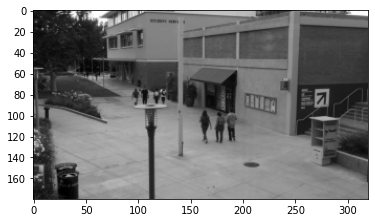

In [ ]:
plt.imshow(np.reshape(M[:,100], dims), cmap='gray'); #100th sample frame

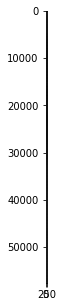

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(M, cmap='gray')

### SVD

In [ ]:
U, s, V = np.linalg.svd(M, full_matrices=False) # numpy SVD

In [ ]:
np.save("U.npy", U)
np.save("s.npy", s)
np.save("V.npy", V)

In [ ]:
U = np.load("U.npy")
s = np.load("s.npy")
V = np.load("V.npy")

In [ ]:
U.shape, s.shape, V.shape

((57600, 400), (400,), (400, 400))

We have 400 singular values.   
1st vector of U, V and 1st singular value represents dimension with maximum explaination of our matrix. Guess what? Maximum variability of matrix is going to be defined by background 

We choose first 10 singular values and first 10 vectors of U,V. These vectors explain maximum variability of original matrix. That part represents the background. We use these vectors to reconstruct the low rank matrix of same shape as original matrix. If we use this reconstructed matrix to make the video. That video will only include background. Now we can get remaining foreground by just subracking low rank matrix from original matrix M. 

Choice of how many singular values to use depends on the quality of video

In [ ]:
s[0]

6.220298613406783e-14

In [ ]:
low_rank = (U[:,0:5] * s[0:5])@V[0:5,:]

In [ ]:
low_rank.shape

(57600, 400)

Display only the background of a sample frame

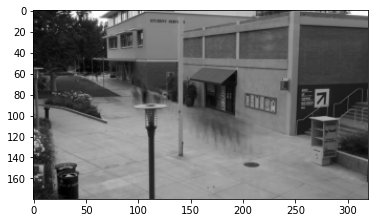

In [ ]:
plt.imshow(np.reshape(low_rank[:,100], dims), cmap='gray');

As we can observe that person is now lost from our sample frame. If we subtract this low rank matrix from M matrix, we will get only foreground. i.e. person walking

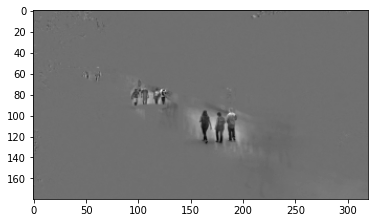

In [ ]:
plt.imshow(np.reshape(M[:,100] - low_rank[:,100], dims), cmap='gray');

### Video
Create a video by subtracting background from each frame in the movie

In [ ]:
from moviepy.video.io.bindings import mplfig_to_npimage

In [ ]:
def make_video(matrix, dims, filename):
    mat_reshaped = np.reshape(matrix, (dims[0], dims[1], -1))
    
    fig, ax = plt.subplots()
    def make_frame(t):
        ax.clear()
        ax.imshow(mat_reshaped[...,int(t*fps)])
        return mplfig_to_npimage(fig)
    
    animation = mpe.VideoClip(make_frame, duration=int(10)) #duration set to 10 seconds
    animation.write_videofile( filename + '.mp4', fps=fps)

[MoviePy] >>>> Building video ped.mp4
[MoviePy] Writing video ped.mp4


100%|█████████▉| 200/201 [00:17<00:00, 11.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ped.mp4 



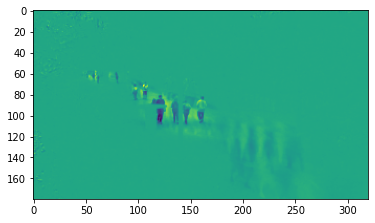

In [ ]:
# create video of pedestrians only
make_video(M - low_rank, dims, "ped")

In [ ]:
# save video
mpe.VideoFileClip("ped.mp4").subclip().ipython_display()

This is only one of many approaches that can be used to achieve background removal from videos. 

## Application 2 - Movie Recommendations

In our next example we will apply SVDs for making movie recommendations. ([source](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/)). There are many approaches for making movie recommendations. Here we will use the approach where given a movie title, we will use SVD to recommend similar movies based on user ratings.

#### Toy Data
To start let us look at a toy example from the MML textbook. To get a sense of what SVD is doing.

In [ ]:
# import required libraries
import numpy as np

In [ ]:
# toy movie matrix
ratings = [[5, 4, 1],
           [5, 5, 0],
           [0, 0, 5],
           [1, 0, 4]]

ratings = np.array(ratings)
ratings

array([[5, 4, 1],
       [5, 5, 0],
       [0, 0, 5],
       [1, 0, 4]])

obtain SVD from toy ratings matrix

In [ ]:
U, S, V = np.linalg.svd(ratings)

In [ ]:
U, S, V

(array([[-0.67096878,  0.02362898, -0.46466034, -0.57735027],
        [-0.7197425 ,  0.20541998,  0.47585716,  0.46188022],
        [-0.09389374, -0.77048084,  0.52682373, -0.34641016],
        [-0.15151103, -0.6029955 , -0.52925183,  0.57735027]]),
 array([9.6438109 , 6.36389089, 0.70555232]),
 array([[-0.73674894, -0.65146317, -0.1810987 ],
        [ 0.0852072 ,  0.17624687, -0.9806512 ],
        [-0.67077622,  0.73792464,  0.07434034]]))

reconstruction using first singular value

In [ ]:
# reconstruction using first singular value
u1 = U[:,0:1]
v1 = V[0:1,:]
A1 = S[0]*u1@v1
A1

array([[4.76727846, 4.21542018, 1.17183466],
       [5.11381898, 4.52184531, 1.25701705],
       [0.66712138, 0.58989567, 0.1639837 ],
       [1.0764961 , 0.95188134, 0.26461123]])

reconstruction using second singular value

In [ ]:
u2 = U[:,1:2]
v2 = V[1:2,:]
A2 = S[1]*u2@v2
A2

array([[ 0.0128128 ,  0.02650264, -0.14746276],
       [ 0.11138885,  0.23040231, -1.28197623],
       [-0.41779272, -0.86418352,  4.80838387],
       [-0.32697391, -0.67632931,  3.76314855]])

reconstruction using third singular value

In [ ]:
# reconstruction using first singular value
u3 = U[:,2:3]
v3 = V[2:3,:]
A3 = S[2]*u3@v3
A3

array([[ 0.21990874, -0.24192282, -0.0243719 ],
       [-0.22520783,  0.24775239,  0.02495918],
       [-0.24932866,  0.27428785,  0.02763243],
       [ 0.2504778 , -0.27555202, -0.02775979]])

By examining A1, A2, and A3 we can see that A1 captures the intersection of scifi-ness (scifi movies and fans). Similarly A2 captures the intersection of French-ness (French movie theme and user fans). Lastly, A3 seems to capture something more subtle that's not as easy to interpret.

Let us examine what happens if we combine A1 and A2 and how it compares to the original ratings.

In [ ]:
np.round(A1+A2)

array([[ 5.,  4.,  1.],
       [ 5.,  5., -0.],
       [ 0., -0.,  5.],
       [ 1.,  0.,  4.]])

Adding A1 and A2 seems to provide a reasonable estimate for A.


we can also reconstruction A using U, S and V

In [ ]:
# construct diagonal singular matrix
n = len(S)
S_diag = np.zeros((4, 3))
S_diag[:n,:n] = np.diag(S)
S_diag

array([[9.6438109 , 0.        , 0.        ],
       [0.        , 6.36389089, 0.        ],
       [0.        , 0.        , 0.70555232],
       [0.        , 0.        , 0.        ]])

In [ ]:
# reconstruct original ratings matrix
A = U@S_diag@V
np.round(A)

array([[ 5.,  4.,  1.],
       [ 5.,  5., -0.],
       [ 0., -0.,  5.],
       [ 1.,  0.,  4.]])

The above toy dataset shows how we can manipulate the results from and SVD to reconstruct our rectangular data matrices. 

#### Large Movie Dataset
Let us now apply SVD to a reasonably large data set of movie ratings to see if we can obtain some recommendations.

In [1]:
# load multiple files: "ratings.dat" and "movies.dat" to Google Colab
from google.colab import files
uploaded = files.upload()

Saving movies.dat to movies.dat
Saving ratings.dat to ratings.dat


In [2]:
# load common libraries
import numpy as np
import pandas as pd

In [3]:
# load movie data
data = pd.io.parsers.read_csv('ratings.dat', 
    names=['user_id', 'movie_id', 'rating', 'time'],
    engine='python', delimiter='::')

movie_data = pd.io.parsers.read_csv('movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

In [4]:
# determine number of movies and users
num_movies = np.max(data.movie_id.values)
num_users = np.max(data.user_id.values)

# initialize a rating matrix
ratings_mat = np.zeros((num_movies, num_users))

# display dimensions
print('Num Movies: ', num_movies)
print('Num Users: ', num_users)
print('Ratings Matrix: ', ratings_mat.shape)

Num Movies:  3952
Num Users:  6040
Ratings Matrix:  (3952, 6040)


In [5]:
ratings_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# movies and user start at 1, adjust to start at 0
ratings_mat[data.movie_id.values-1, data.user_id.values-1] = data.rating.values

In [8]:
# flip dimensions so it is users x movies
A = ratings_mat.T

# apply svd
U, S, V = np.linalg.svd(A)

Helper Functions

In [9]:
# use cosine similarity to find indices of similar movies
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id - 1 # Movie id starts from 1 in the dataset
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indices = np.argsort(-similarity)
    return sort_indices[:top_n]

# find movies by indices
def print_similar_movies(movie_data, movie_id, top_indices):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id in top_indices + 1:
        print(movie_data[movie_data.movie_id == id].title.values[0])

In [12]:
# obtain a list of movies by representing them using k components
k = 50
movie_id = 10 # (getting an id from movies.dat)
top_n = 10
sliced = V.T[:, :k] # representative data

# list movies
indices = top_cosine_similarity(sliced, movie_id, top_n)
print_similar_movies(movie_data, movie_id, indices)

# sample movie indices based on movies.dat file
# 10 - GoldenEye, 
# 1200 - Aliens, 
# 1214 - Alien, 
# 1196 - Star Wars Episode V, 
# 1207 - To Kill a Mockingbird

Recommendations for GoldenEye (1995): 

GoldenEye (1995)
Tomorrow Never Dies (1997)
World Is Not Enough, The (1999)
Mission: Impossible (1996)
Mask of Zorro, The (1998)
Licence to Kill (1989)
Rush Hour (1998)
Enemy of the State (1998)
Clear and Present Danger (1994)
Rock, The (1996)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Normally we would not apply SVD unless we had accurate information for all the ratings. By providing a zero rating, we are in a sense creating poor ratings for a large number of movies. Even so, it seems to do reasonably well.

We will revisit this problem when we talk about optimization (requires vector calculus) to show how we can better approximate the ratings.

## Application 3 - Topic Extraction

In this example we will look into how PCA can be used to identify representative topics from a large data set of news articles ([source](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb)).

In [ ]:
# import common libraries
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [ ]:
# load news groups from sklearn builtin datasets
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [ ]:
newsgroups_train.filenames[:5]

array(['/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38816',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/talk.religion.misc/83741',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/61092',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/alt.atheism/51306',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60903'],
      dtype='<U86')

In [ ]:
newsgroups_train.target[:5]

#check order of labels

array([1, 3, 2, 0, 2])

In [ ]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [ ]:
# topic from computer graphics
print('\n'.join(newsgroups_train.data[:1]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


In [ ]:
# topic about science and space
print('\n'.join(newsgroups_train.data[2:3]))


 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

 


In [ ]:
newsgroups_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [ ]:
# confirming from target names

np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

Next, scikit learn has a method that will extract all the word counts for us.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

`columns` represent unique words  
`rows` represent number of documents   
`cells` represent number of occurence of word in document i  

In [ ]:
# get all words unique words from corpus of docs
vocab = np.array(vectorizer.get_feature_names())

In [ ]:
vocab.shape

(26576,)

In [ ]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

SVD applied on the [documents x words] matrix

In [ ]:
U, s, Vh = linalg.svd(vectors, full_matrices=False)

In [ ]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


`s` are singular values in decreasing order

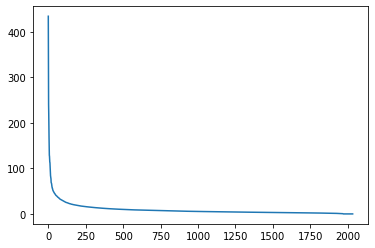

In [ ]:
plt.plot(s);

Exploring Topics

In [ ]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

We can see that topics are telling something. For example,   
`Topic 7` is related to `space`.  
`Topic 3` is related to `computer graphics`.  
`topic 2` is related to `image quality` etc.
